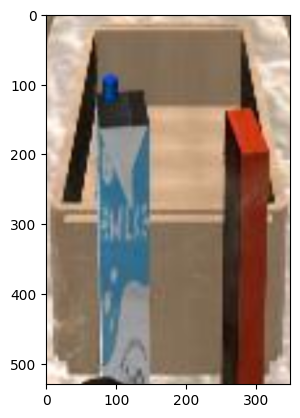

In [25]:
from PIL import Image
import matplotlib.pyplot as plt

base_image = Image.open("/home/owenburns/lerf/outputs/renders/lerf.png")

bboxes = {
    "apple": [(1055, 1325), (1200, 1745)],
    "banana": [(970, 660), (1100, 940)],
    "cereal": [(1025, 170), (1100, 680)],
    "milk": [(850, 120), (935, 605)],
    "box": [(780, 40), (1130, 570)]
}

# apple_bbox = (1055, 1325, 1200, 1745)
# banana_bbox = (970, 660, 1100, 940)
# cereal_bbox = (1025, 170, 1100, 680)
# milk_bbox = (850, 120, 935, 605)
# box_bbox = (780, 40, 1130, 570)
base_image = base_image.crop((780, 40, 1130, 570))

plt.imshow(base_image)

In [73]:
from scipy.spatial import KDTree
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
# compute the IoU score

# bounding_box = bboxes['bin']
# def get_union_bbox(bboxes):
#     bboxes_ = np.array(bboxes).reshape(-1, 6)
#     return np.array([np.min(bboxes_[:, :3], axis=0), np.max(bboxes_[:, 3:], axis=0)])

# bounding_box = get_union_bbox([bboxes['bin'], bboxes['cereal'], bboxes['milk']])

relevance_map = Image.open("/home/owenburns/lerf/outputs/renders/lerf_cereal.png")
image_rgb = relevance_map.convert('RGB')
image_array = np.array(image_rgb)
normalized_array = image_array / 255.0

def unmap_nearest(img, rgb):
    """ img is an image of shape [n, m, 3], and rgb is a colormap of shape [k, 3]. """
    d = np.sum(np.abs(img[np.newaxis, ...] - rgb[:, np.newaxis, np.newaxis, :]), axis=-1)    
    i = np.argmin(d, axis=0)
    return i / (rgb.shape[0] - 1)


dz = np.arange(0, 100, 1)
norm = plt.Normalize()
colors = plt.cm.turbo(norm(dz))
colors = colors[:, :3]

grayscale = unmap_nearest(normalized_array, colors)

In [68]:
model_chosen_points = np.argwhere(grayscale >= 0.70)
print(model_chosen_points.shape)

(22185, 2)


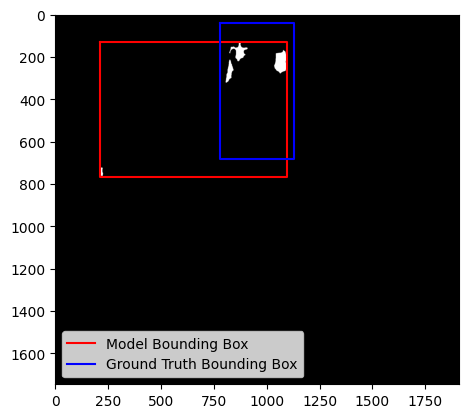

0.2843460226479762


In [72]:
model_chosen_points = np.argwhere(grayscale >= 0.7)

# get rid of outliers
radius_threshold = 10
min_neighbors = 300
tree = KDTree(model_chosen_points)

filtered_points = []
for point in model_chosen_points:
    neighbors = tree.query_ball_point(point, r=radius_threshold)
    if len(neighbors) >= min_neighbors:
        filtered_points.append(point)

model_chosen_points = np.array(filtered_points)

min_x = model_chosen_points[:, 0].min()
max_x = model_chosen_points[:, 0].max()
min_y = model_chosen_points[:, 1].min()
max_y = model_chosen_points[:, 1].max()
model_bounding_box = [(min_y, min_x), (max_y, max_x)]

def get_union_bbox(bboxes):
    bboxes_ = np.array(bboxes).reshape(-1, 4)
    return np.array([np.min(bboxes_[:, :2], axis=0), np.max(bboxes_[:, 2:], axis=0)])
gt_bounding_box = get_union_bbox([bboxes['box'], bboxes['cereal'], bboxes['milk']])

img = np.zeros_like(grayscale)
img[model_chosen_points[:, 0], model_chosen_points[:, 1]] = 1

import matplotlib.pyplot as plt

# Plot the bounding boxes
def plot_bbox(bbox, color, label):
    min_x, min_y = bbox[0]
    max_x, max_y = bbox[1]
    plt.plot([min_x, max_x, max_x, min_x, min_x], [min_y, min_y, max_y, max_y, min_y], color=color, label=label)

# Plot the image
plt.imshow(img, cmap='gray')

# Plot the model bounding box
plot_bbox(model_bounding_box, color='red', label='Model Bounding Box')

# Plot the ground truth bounding box
plot_bbox(gt_bounding_box, color='blue', label='Ground Truth Bounding Box')

# Add legend
plt.legend()

# Show the plot
plt.show()

def iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0][0], boxB[0][0])
    yA = max(boxA[0][1], boxB[0][1])
    xB = min(boxA[1][0], boxB[1][0])
    yB = min(boxA[1][1], boxB[1][1])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)
    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[1][0] - boxA[0][0]) * (boxA[1][1] - boxA[0][1])
    boxBArea = (boxB[1][0] - boxB[0][0]) * (boxB[1][1] - boxB[0][1])
    # compute the intersection over union by taking the intersection area and dividing it by the sum of prediction + ground-truth areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou



iou_score = iou(gt_bounding_box, model_bounding_box)
print(iou_score)

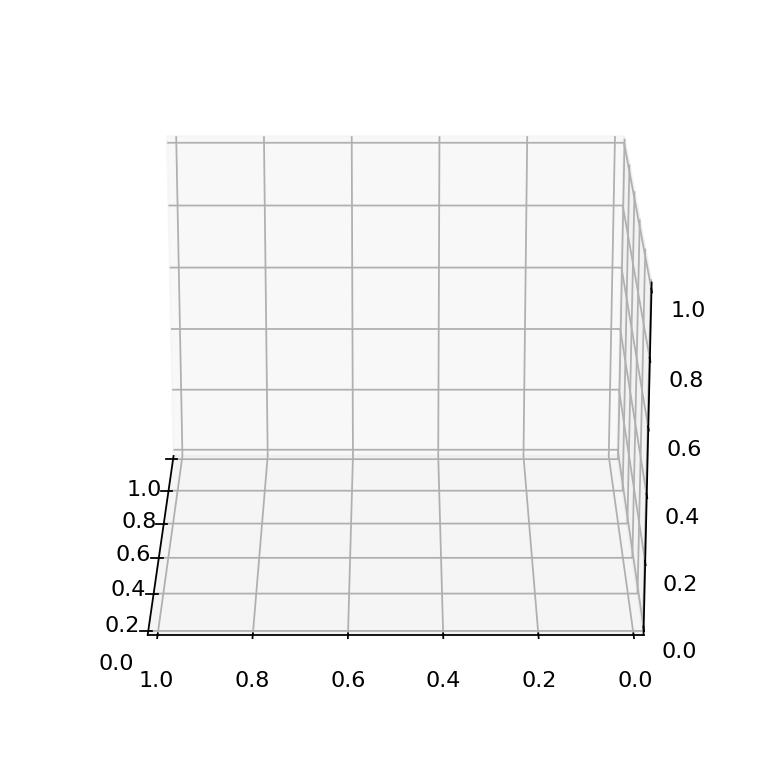

In [32]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
import open3d as o3d

fig = plt.figure(figsize=(6, 6), dpi=160)
ax = fig.add_subplot(111, projection="3d")
ax.view_init(elev=20,azim=180)

cmap = colormaps.get_cmap('jet')
similarity_colormap = cmap(similarity_rel_thresholded[0].detach().cpu().numpy())[:, :3]
plot_colors = similarity_colormap * 0.5

# # plot the point cloud
# ax.scatter(
#     xyz_pts[:, 0],
#     xyz_pts[:, 1],
#     xyz_pts[:, 2],
#     c=plot_colors,
#     s=1,  # type: ignore
#     alpha=0.01
# )

# def get_corners(bbox):
#     min_point = bbox[0]
#     max_point = bbox[1]
#     corners = np.array([
#         [min_point[0], min_point[1], min_point[2]],
#         [min_point[0], max_point[1], min_point[2]],
#         [max_point[0], max_point[1], min_point[2]],
#         [max_point[0], min_point[1], min_point[2]],
#         [min_point[0], min_point[1], max_point[2]],
#         [min_point[0], max_point[1], max_point[2]],
#         [max_point[0], max_point[1], max_point[2]],
#         [max_point[0], min_point[1], max_point[2]],
#     ])
#     return corners

# def plot_wireframe_box(ax, corners, color="blue"):
#     # Define the edges of the box by connecting the corresponding corners
#     edges = [
#         [0, 1], [1, 2], [2, 3], [3, 0],  # Bottom face
#         [4, 5], [5, 6], [6, 7], [7, 4],  # Top face
#         [0, 4], [1, 5], [2, 6], [3, 7]   # Vertical edges
#     ]
#     for edge in edges:
#         ax.plot(
#             [corners[edge[0], 0], corners[edge[1], 0]],
#             [corners[edge[0], 1], corners[edge[1], 1]],
#             [corners[edge[0], 2], corners[edge[1], 2]],
#             color=color
#         )

# # plot the model's bounding box
# model_corners = get_corners(model_bounding_box)
# plot_wireframe_box(ax, model_corners, color="darkviolet")

# # plot the ground truth bounding box
# gt_corners = get_corners(bboxes['banana'])
# plot_wireframe_box(ax, gt_corners, color="red")

# # Show the plot
# plt.legend(["Model's Bounding Box", "Ground Truth Bounding Box"])
# plt.show()
# plt.close(fig)

In [38]:
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(xyz_pts)
point_cloud.colors = o3d.utility.Vector3dVector(plot_colors)

# Plot the bounding boxes
def create_bounding_box_points_and_lines(bbox, color):
    min_point = bbox[0]
    max_point = bbox[1]

    corners = np.array([
        [min_point[0], min_point[1], min_point[2]],
        [min_point[0], max_point[1], min_point[2]],
        [max_point[0], max_point[1], min_point[2]],
        [max_point[0], min_point[1], min_point[2]],
        [min_point[0], min_point[1], max_point[2]],
        [min_point[0], max_point[1], max_point[2]],
        [max_point[0], max_point[1], max_point[2]],
        [max_point[0], min_point[1], max_point[2]],
    ])

    # Create points and colors for the bounding box
    bbox_points = o3d.utility.Vector3dVector(corners)
    bbox_colors = o3d.utility.Vector3dVector([color for _ in range(corners.shape[0])])

    return bbox_points, bbox_colors

gt_bbox_points, gt_bbox_colors = create_bounding_box_points_and_lines(bounding_box, color=[1, 0, 0])  # Red color
model_bbox_points, model_bbox_colors = create_bounding_box_points_and_lines(model_bounding_box, color=[1, 1, 0])  # Yellow color

# Combine all points and colors
combined_points = np.vstack((np.asarray(point_cloud.points), np.asarray(gt_bbox_points), np.asarray(model_bbox_points), np.asarray(model_chosen_points)))#, np.asarray(outputs['xyz_pts'][outputs['segmentation_pts']["banana"]])))
combined_colors = np.vstack((np.asarray(point_cloud.colors), np.asarray(gt_bbox_colors), np.asarray(model_bbox_colors), np.array([[1,1,0]]*model_chosen_points.shape[0])))#, np.asarray(outputs['rgb_pts'][outputs['segmentation_pts']["banana"]]/255.0)))

# Create a new point cloud with combined points and colors
combined_point_cloud = o3d.geometry.PointCloud()
combined_point_cloud.points = o3d.utility.Vector3dVector(combined_points)
combined_point_cloud.colors = o3d.utility.Vector3dVector(combined_colors)

# Save the combined point cloud to a .ply file
o3d.io.write_point_cloud("colored_pointcloud_with_bboxes.ply", combined_point_cloud)

True